In [109]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
device = "cpu"

Device: cuda:0


In [110]:
import numpy as np
import os
from get_data import get_data
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.tensorflow import balanced_batch_generator
from numpy.random import default_rng
rng = default_rng(seed = 31)
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV
import geopandas as gpd
import shapely
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
import libpysal
from copy import deepcopy
import matplotlib.pyplot as plt

In [111]:
from torch import nn, optim
import scipy.ndimage as ndimage

In [112]:
# X, Y, ID = get_data("../Data/filled/grids/", [2015,2016,2017,2018,2019])

In [113]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [114]:
def load_data(year):
    os.getcwd()
    
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [115]:
# df15 = load_data(2015)
# df16 = load_data(2016)
df17 = load_data(2017)
df18 = load_data(2018)
df19 = load_data(2019)

In [116]:
X_train = df17[df17.columns[:-4]]
Y_train = df17.y
Y1_train = df17["y-1"]
# print(X_train)
# X_train = ss.fit_transform(X_train)

X_val = df18[df18.columns[:-4]]
Y_val = df18.y
Y1_val = df18["y-1"]

wt = libpysal.weights.DistanceBand.from_dataframe(df17, threshold=150, binary = True, silence_warnings = True)
wv =libpysal.weights.DistanceBand.from_dataframe(df18, threshold=150, binary = True, silence_warnings = True)

In [117]:
neighbors = [wt.neighbors[x] for x in wt.neighbors]
Y1_train = np.array([Y1_train[x].sum() for x in neighbors])
Y1_train[np.where(Y1_train == 0)[0]] = 0.5

neighbors = [wv.neighbors[x] for x in wv.neighbors]
Y1_val = np.array([Y1_val[x].sum() for x in neighbors])
Y1_val[np.where(Y1_val == 0)[0]] = 0.5



In [118]:
X_train = ss.fit_transform(X_train)
X_train[:,-1] = Y1_train
X_val = ss.transform(X_val)
X_val[:,-1] = Y1_val

In [119]:
oversample = SMOTE()
x, y =  oversample.fit_resample(X_train, Y_train)

In [120]:
x[x[:,-1]>0.5][:,-1] =  np.ceil(x[x[:,-1] > 0.5][:,-1]) # 0.5 means no neighbors, otherwise make int


x = torch.tensor(x).float().to(device)
y = torch.tensor(y).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
Y_val = torch.tensor(Y_val).float().to(device)

In [121]:
rng = default_rng()
def get_batch(X, Y, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs]



In [122]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [123]:
class Model1(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,100),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(50,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [124]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model2(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,500),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(500,100),
            nn.ReLU(),
            nn.Linear(100,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [125]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model3(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [126]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model4(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,40),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(40,80),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(80,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [127]:
model = Model().to(device)
model1 = Model1().to(device)
model2 = Model2().to(device)
model3 = Model3().to(device)
model4 = Model4().to(device)

models = [model, model1, model2, model3, model4]

In [128]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
        for lr in [0.00000051, 0.0000051, 0.000000051]:
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            ROC_history = []

            for epoch in range(num_epochs):
                epoch_loss = []
#                 print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y = get_batch(X_train, Y_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

model: 0, ROC:0.3786145845087037, f1: 0.11600496277915633, lr: 5.1e-07, epoch = 0
model: 0, ROC:0.3803460808835719, f1: 0.11910669975186104, lr: 5.1e-07, epoch = 1
model: 0, ROC:0.3821204696606363, f1: 0.12158808933002481, lr: 5.1e-07, epoch = 2
model: 0, ROC:0.38421512446489975, f1: 0.12158808933002481, lr: 5.1e-07, epoch = 3
model: 0, ROC:0.3867608319653538, f1: 0.12531017369727046, lr: 5.1e-07, epoch = 4
model: 0, ROC:0.3894154869946266, f1: 0.12903225806451613, lr: 5.1e-07, epoch = 5
model: 0, ROC:0.3923424281219299, f1: 0.12841191066997518, lr: 5.1e-07, epoch = 6
model: 0, ROC:0.3947344344010136, f1: 0.1327543424317618, lr: 5.1e-07, epoch = 7
model: 0, ROC:0.397150223834642, f1: 0.13771712158808933, lr: 5.1e-07, epoch = 8
model: 0, ROC:0.3998201828068391, f1: 0.13833746898263027, lr: 5.1e-07, epoch = 9
model: 0, ROC:0.4028894506033393, f1: 0.141439205955335, lr: 5.1e-07, epoch = 10
model: 0, ROC:0.4052534961650801, f1: 0.1445409429280397, lr: 5.1e-07, epoch = 11
model: 0, ROC:0.40

model: 0, ROC:0.6428637962315571, f1: 0.3219602977667494, lr: 5.1e-07, epoch = 100
model: 0, ROC:0.6432647181741684, f1: 0.3225806451612903, lr: 5.1e-07, epoch = 101
model: 0, ROC:0.6438998318055311, f1: 0.3232009925558313, lr: 5.1e-07, epoch = 102
model: 0, ROC:0.6443277217772956, f1: 0.3232009925558313, lr: 5.1e-07, epoch = 103
model: 0, ROC:0.644898889744439, f1: 0.3232009925558313, lr: 5.1e-07, epoch = 104
model: 0, ROC:0.6452940210059438, f1: 0.3232009925558313, lr: 5.1e-07, epoch = 105
model: 0, ROC:0.6458888066796004, f1: 0.32444168734491313, lr: 5.1e-07, epoch = 106
model: 0, ROC:0.6464146832480889, f1: 0.3250620347394541, lr: 5.1e-07, epoch = 107
model: 0, ROC:0.6468685899228251, f1: 0.32568238213399503, lr: 5.1e-07, epoch = 108
model: 0, ROC:0.6472549110766465, f1: 0.32568238213399503, lr: 5.1e-07, epoch = 109
model: 0, ROC:0.6474955138766227, f1: 0.32568238213399503, lr: 5.1e-07, epoch = 110
model: 0, ROC:0.6479944224159582, f1: 0.32568238213399503, lr: 5.1e-07, epoch = 111


model: 0, ROC:0.667483704196126, f1: 0.3325062034739454, lr: 5.1e-07, epoch = 199
model: 0, ROC:0.667722321619723, f1: 0.3325062034739454, lr: 5.1e-07, epoch = 200
model: 0, ROC:0.6677452361721017, f1: 0.3325062034739454, lr: 5.1e-07, epoch = 201
model: 0, ROC:0.6679416643476368, f1: 0.3325062034739454, lr: 5.1e-07, epoch = 202
model: 0, ROC:0.668062813668787, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 203
model: 0, ROC:0.6681401192615591, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 204
model: 0, ROC:0.6682581250701086, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 205
model: 0, ROC:0.668363680914279, f1: 0.3337468982630273, lr: 5.1e-07, epoch = 206
model: 0, ROC:0.6684303978330278, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 207
model: 0, ROC:0.6686572684463802, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 208
model: 0, ROC:0.66884984995518, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 209
model: 0, ROC:0.668963016408805, f1: 0.33312655086848636, lr: 5.1e-07, epoch = 210
mode

model: 0, ROC:0.6768351164770687, f1: 0.34181141439205953, lr: 5.1e-07, epoch = 299
model: 0, ROC:0.676903818772197, f1: 0.34181141439205953, lr: 5.1e-07, epoch = 300
model: 0, ROC:0.6769371979125753, f1: 0.34181141439205953, lr: 5.1e-07, epoch = 301
model: 0, ROC:0.6770647169829427, f1: 0.3411910669975186, lr: 5.1e-07, epoch = 302
model: 0, ROC:0.67715534114226, f1: 0.3411910669975186, lr: 5.1e-07, epoch = 303
model: 0, ROC:0.6771766425763301, f1: 0.34181141439205953, lr: 5.1e-07, epoch = 304
model: 0, ROC:0.6772194522545107, f1: 0.3411910669975186, lr: 5.1e-07, epoch = 305
model: 0, ROC:0.6772932007146031, f1: 0.3411910669975186, lr: 5.1e-07, epoch = 306
model: 0, ROC:0.6774150118278798, f1: 0.3411910669975186, lr: 5.1e-07, epoch = 307
model: 0, ROC:0.6775171346253942, f1: 0.3411910669975186, lr: 5.1e-07, epoch = 308
model: 0, ROC:0.6775588688913692, f1: 0.3424317617866005, lr: 5.1e-07, epoch = 309
model: 0, ROC:0.6776424201473349, f1: 0.3424317617866005, lr: 5.1e-07, epoch = 310
mod

model: 0, ROC:0.6827525721378235, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 415
model: 0, ROC:0.6828868745774871, f1: 0.34305210918114143, lr: 5.1e-07, epoch = 416
model: 0, ROC:0.682923479954482, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 417
model: 0, ROC:0.6830449188096874, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 418
model: 0, ROC:0.6831112221083573, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 419
model: 0, ROC:0.6831261537932105, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 420
model: 0, ROC:0.683184805120418, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 421
model: 0, ROC:0.6832546655517675, f1: 0.34491315136476425, lr: 5.1e-07, epoch = 423
model: 0, ROC:0.6833113315025957, f1: 0.34491315136476425, lr: 5.1e-07, epoch = 424
model: 0, ROC:0.6833337083488716, f1: 0.34491315136476425, lr: 5.1e-07, epoch = 425
model: 0, ROC:0.6833418153024209, f1: 0.34491315136476425, lr: 5.1e-07, epoch = 426
model: 0, ROC:0.6834128752319995, f1: 0.34491315136476425, lr: 5.1e-07, epoch = 427


model: 0, ROC:0.6874757825443724, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 566
model: 0, ROC:0.6875242174556276, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 567
model: 0, ROC:0.6875484555922592, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 572
model: 0, ROC:0.6875668203237686, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 574
model: 0, ROC:0.687635439894881, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 575
model: 0, ROC:0.6877684601122995, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 576
model: 0, ROC:0.6877762775317933, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 577
model: 0, ROC:0.6878053963853576, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 582
model: 0, ROC:0.6878070922276817, f1: 0.3442928039702233, lr: 5.1e-07, epoch = 583
model: 0, ROC:0.687846468859206, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 584
model: 0, ROC:0.6878838601143511, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 585
model: 0, ROC:0.6879351490041518, f1: 0.3436724565756824, lr: 5.1e-07, epoch = 589
model:

model: 0, ROC:0.6906687641065129, f1: 0.34801488833746896, lr: 5.1e-07, epoch = 1147
model: 0, ROC:0.6906694672606473, f1: 0.34739454094292804, lr: 5.1e-07, epoch = 1148
model: 0, ROC:0.6906778637482516, f1: 0.34739454094292804, lr: 5.1e-07, epoch = 1149
model: 0, ROC:0.6907337851829376, f1: 0.34739454094292804, lr: 5.1e-07, epoch = 1150
model: 0, ROC:0.6907432984447553, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1237
model: 0, ROC:0.6907573615274427, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1240
model: 0, ROC:0.690869452568862, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1242
model: 0, ROC:0.6908790899167035, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1243
model: 0, ROC:0.6909413397385988, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1268
model: 0, ROC:0.690951101172464, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1276
model: 0, ROC:0.6909786482697279, f1: 0.34863523573200994, lr: 5.1e-07, epoch = 1277
model: 0, ROC:0.6910033413884465, f1: 0.34863523573200994, lr: 5.1e

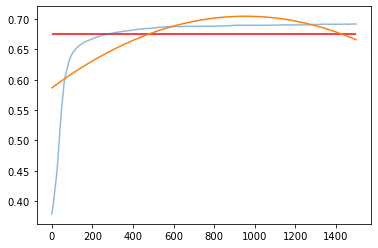

model: 0, ROC:0.6922050318040751, f1: 0.3523573200992556, lr: 5.1e-06, epoch = 2
model: 0, ROC:0.6930453423566483, f1: 0.35173697270471466, lr: 5.1e-06, epoch = 3
model: 0, ROC:0.6932431768404521, f1: 0.3529776674937965, lr: 5.1e-06, epoch = 13
model: 0, ROC:0.6933097696731773, f1: 0.3542183622828784, lr: 5.1e-06, epoch = 84
model: 0, ROC:0.6933347523259511, f1: 0.3535980148883375, lr: 5.1e-06, epoch = 85
model: 0, ROC:0.6933825254450801, f1: 0.3542183622828784, lr: 5.1e-06, epoch = 86
model: 0, ROC:0.693781916993399, f1: 0.3542183622828784, lr: 5.1e-06, epoch = 87
model: 0, ROC:0.6938103740548368, f1: 0.3535980148883375, lr: 5.1e-06, epoch = 88
model: 0, ROC:0.6941129785046609, f1: 0.3535980148883375, lr: 5.1e-06, epoch = 89
model: 0, ROC:0.6944764264681114, f1: 0.3542183622828784, lr: 5.1e-06, epoch = 93
model: 0, ROC:0.6944945430275733, f1: 0.35483870967741943, lr: 5.1e-06, epoch = 94
model: 0, ROC:0.694888019808762, f1: 0.3529776674937965, lr: 5.1e-06, epoch = 95
model: 0, ROC:0.69

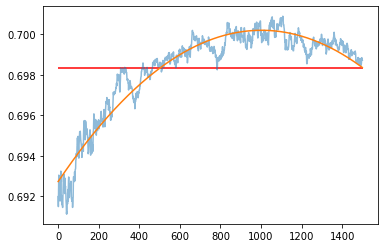

0.6989845544335606 1495 5.1e-08


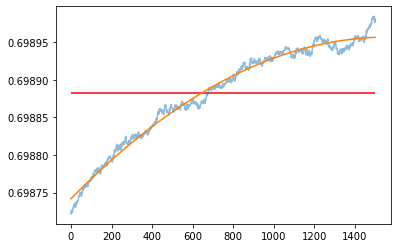

0.6693404860929347 1499 5.1e-07


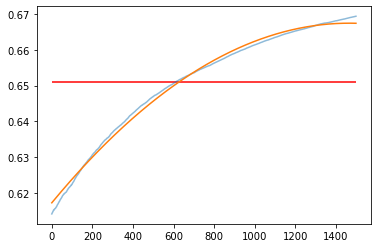

0.6953613666272128 1348 5.1e-06


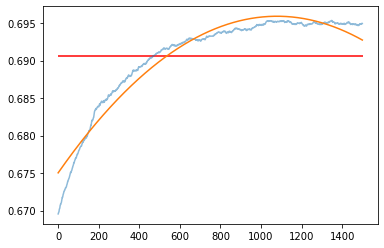

0.695066414148851 1487 5.1e-08


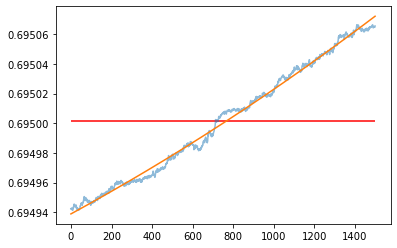

0.6949491114944357 1440 5.1e-07


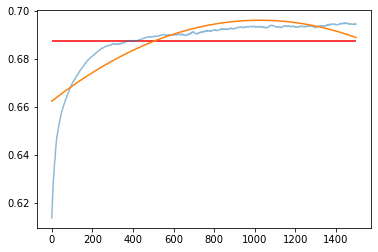

0.6998943117974042 557 5.1e-06


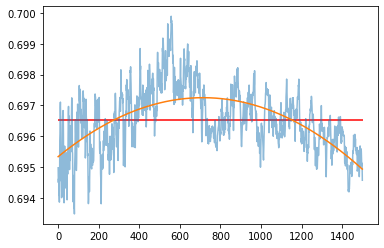

In [ ]:
n_epochs = 1500
hists = train(models, x, y, Y1_train, X_val, Y_val, Y1_val, n_epochs, 0.0000051)

# Neighbor function

In [12]:
def neighbor_part(model, X, idxs, w):
    preds = model(torch.from_numpy(X).float())
    preds = pd.DataFrame(np.array(preds.detach())).set_index(idxs)
    
    neighbors = [w.neighbors[x] for x in idxs]
    transitions = [preds.loc[x].values for x in neighbors]



    n_function = np.zeros((len(preds), w.max_neighbors + 1))
    for i, (t, idx) in enumerate(zip(transitions, idxs)):
        n_function[i, 1:len(t) + 1] = t.squeeze()
        n_function[i, 0] = preds.loc[idx]
        
    return n_function

In [13]:
w15 = libpysal.weights.DistanceBand.from_dataframe(df15, threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16, threshold=150, binary = True, silence_warnings = True)

for mod in models:
    hists = train_model(mod, x_train, y_train, X_val, Y_val, 250)
    n_function = neighbor_part(mod, X_train, df15.index, w15)
        
    oversample = SMOTE()
    x, y = oversample.fit_resample(n_function, Y_train)

    clf_bagger = RandomForestClassifier(max_depth = 12, oob_score = True)
    clf_bagger.fit(x,y)
    
    n_function = neighbor_part(mod, X_val, df16.index, w16)
    preds = clf_bagger.predict(n_function)
    totacc = accuracy_score(Y_val, preds)
    totf1 = f1_score(Y_val, preds)
    totROC = roc_auc_score(Y_val, preds)
    
    
    with open("../results/mlp/" + mod.name + ".csv", "a+") as f:
        f.write("loss;acc;ROC;f1_score\n")
        f.write(str(hists[2]) + ";" + str(hists[0]) + ";" + str(hists[1]) + ";" + str(hists[3]) + "\n")
        f.write("--;" + str(totacc) + ";" + str(totROC) + ";"  + str(totf1))
    
    
    

NameError: name 'models' is not defined

In [246]:
neighbor_part(model, X_train, df15.index, w15)

In [24]:
X_val

array([[-0.20477431, -0.06709367, -0.24659556, ...,  0.46299088,
         0.45272231,  0.69077765],
       [-0.20477431, -0.06709367, -0.24659556, ...,  0.2866995 ,
         0.16036807, -0.03776353],
       [-0.20477431, -0.06709367,  1.24801218, ...,  0.80675908,
         0.81004415,  0.84689361],
       ...,
       [-0.20477431, -0.06709367, -0.24659556, ...,  0.68335511,
         0.79380225,  0.11835244],
       [-0.20477431, -0.06709367, -0.24659556, ...,  1.49870277,
         1.28105931,  0.48262303],
       [-0.20477431, -0.06709367, -0.24659556, ...,  1.30037496,
         1.24857551,  0.11835244]])

In [281]:
hists

([0.7477, 0.7461],
 [0.4551122194513716, 0.45591939546599497],
 [0.1489188086495308, 0.14661806399351965],
 [0.23744001984596252, 0.2417915314435959])

In [257]:
np.sum(preds == 1)

15948

In [165]:
# X_train = torch.from_numpy(X_train).float()
preds = model(X_train)

In [166]:
w15 = libpysal.weights.DistanceBand.from_dataframe(df15, threshold=150, binary = True, silence_warnings = True)


In [167]:
import pandas as pd

preds = pd.DataFrame(np.array(preds.detach())).set_index(df15.index)

In [168]:

# preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_train)
neighbors = [w15.neighbors[x] for x in df15.index]
transitions = [preds.loc[x].values for x in neighbors]



n_function = np.zeros((len(preds), w15.max_neighbors + 1))
for i, (t, idx) in enumerate(zip(transitions, df15.index)):
    n_function[i, 1:len(t) + 1] = t.squeeze()
    n_function[i, 0] = preds.loc[idx]

In [169]:
params = {"max_depth": [12], "oob_score" : [True, False]}
clf_bagger = GridSearchCV(RandomForestClassifier(), params, cv = 5, scoring = "balanced_accuracy",
                               verbose = 3)
clf_bagger = RandomForestClassifier(max_depth = 12, oob_score = True)
oversample = SMOTE()
x, y = oversample.fit_resample(n_function, Y_train)

clf_bagger.fit(x,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......max_depth=6, oob_score=True;, score=0.855 total time=   6.5s
[CV 2/5] END .......max_depth=6, oob_score=True;, score=0.865 total time=   6.4s
[CV 3/5] END .......max_depth=6, oob_score=True;, score=0.863 total time=   6.5s
[CV 4/5] END .......max_depth=6, oob_score=True;, score=0.829 total time=   6.2s
[CV 5/5] END .......max_depth=6, oob_score=True;, score=0.833 total time=   6.2s
[CV 1/5] END ......max_depth=6, oob_score=False;, score=0.855 total time=   5.7s
[CV 2/5] END ......max_depth=6, oob_score=False;, score=0.865 total time=   5.9s
[CV 3/5] END ......max_depth=6, oob_score=False;, score=0.862 total time=   6.7s
[CV 4/5] END ......max_depth=6, oob_score=False;, score=0.829 total time=   6.1s
[CV 5/5] END ......max_depth=6, oob_score=False;, score=0.833 total time=   6.0s
[CV 1/5] END .......max_depth=8, oob_score=True;, score=0.853 total time=   9.3s
[CV 2/5] END .......max_depth=8, oob_score=True;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10, 12],
                         'oob_score': [True, False]},
             scoring='balanced_accuracy', verbose=3)

In [170]:
clf_bagger.best_params_

{'max_depth': 12, 'oob_score': False}

In [171]:
np.array(preds.detach())

AttributeError: 'DataFrame' object has no attribute 'detach'

In [173]:
# X_val = torch.from_numpy(X_val).float()
preds = model(X_val)

In [174]:
w16 = libpysal.weights.DistanceBand.from_dataframe(df16, threshold=150, binary = True, silence_warnings = True)


In [175]:
preds = pd.DataFrame(np.array(preds.detach())).set_index(df16.index)
neighbors = [w16.neighbors[x] for x in df16.index]
transitions = [preds.loc[x].values for x in neighbors]



n_function = np.zeros((len(preds), w16.max_neighbors + 1))
for i, (t, idx) in enumerate(zip(transitions, df16.index)):
    n_function[i, 1:len(t) + 1] = t.squeeze()
    n_function[i, 0] = preds.loc[idx]

In [176]:
preds = clf_bagger.predict(n_function)

In [177]:
len(neighbors)

57050

In [178]:
clf_bagger.score(n_function, Y_val)

0.5819144337554594

In [179]:
recall_score(Y_val, preds)

0.3210421726650475

In [180]:
precision_score(Y_val, preds)

0.14972711358253527

In [246]:
(Y_val == 1).sum()

4529

# No bagger on the end

In [277]:
preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_val)

In [279]:
preds["y"] = Y_val

In [280]:
preds = preds.sort_values(by=[0], ascending = False)

In [281]:
preds

,0,y
3699708.0,9.999919e-01,0.0
2206980.0,9.999806e-01,0.0
2206983.0,9.999349e-01,0.0
2206982.0,9.999343e-01,0.0
2210563.0,9.999300e-01,0.0
...,...,...
2654130.0,3.897061e-21,0.0
2113362.0,1.054448e-21,0.0
3705586.0,2.995088e-22,0.0
3703981.0,6.478963e-23,0.0


In [282]:
preds[0].iloc[0:4529] = 1
preds[0].iloc[4529:] = 0

In [283]:
recall_score(preds["y"], preds[0])


0.17244424817840584

In [284]:
precision_score(preds["y"], preds[0])

0.17244424817840584